In [6]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")

    return image

def detect_damage_sift(original_path, damaged_path, threshold=0.7):
    try:
        original = load_image(original_path)
        damaged = load_image(damaged_path)
    except (FileNotFoundError, ValueError) as e:
        print(f"Error: {e}")
        return None, None

    # Convert to grayscale
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    damaged_gray = cv2.cvtColor(damaged, cv2.COLOR_BGR2GRAY)

    # Create SIFT object
    sift = cv2.SIFT_create()  # Note: Changed from cv2.xfeatures2d.SIFT_create()

    # Extract keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(original_gray, None)
    kp2, des2 = sift.detectAndCompute(damaged_gray, None)

    # FLANN matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Ensure descriptors exist
    if des1 is None or des2 is None:
        print("Error: No descriptors found in one or both images.")
        return None, None

    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < threshold * n.distance:
            good_matches.append(m)

    # Find unmatched keypoints (potential damage)
    matched_kp2 = set([match.trainIdx for match in good_matches])
    unmatched_kp2 = set(range(len(kp2))) - matched_kp2

    # Create result image
    result = damaged.copy()

    # Mark damaged areas (in red)
    for idx in unmatched_kp2:
        x, y = map(int, kp2[idx].pt)
        cv2.circle(result, (x, y), 5, (0, 0, 255), -1)

    # Calculate damage ratio
    damage_ratio = len(unmatched_kp2) / len(kp2) if kp2 else 0

    return result, damage_ratio

def draw_keypoints(image, keypoints):
    return cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Usage example


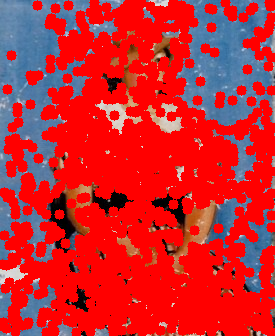

Damage ratio: 95.42%


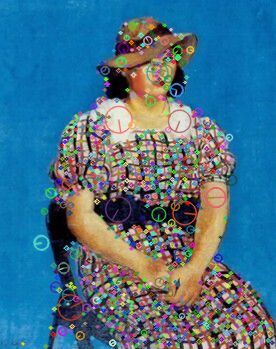

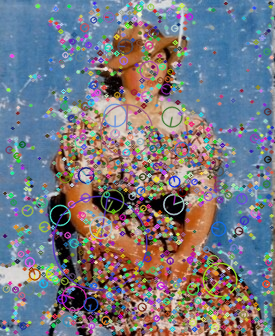

In [ ]:
original_path = '/content/drive/MyDrive/KeyPoint/images/origin.png'  # Update with your path
damaged_path = '/content/drive/MyDrive/KeyPoint/images/impairment.png'   # Update with your path

result, damage_ratio = detect_damage_sift(original_path, damaged_path)

if result is not None and damage_ratio is not None:
    # Display result
    cv2_imshow(result)
    print(f"Damage ratio: {damage_ratio:.2%}")

    # Visualize keypoints
    try:
        original = load_image(original_path)
        damaged = load_image(damaged_path)

        sift = cv2.SIFT_create()  # Note: Changed from cv2.xfeatures2d.SIFT_create()
        kp_original = sift.detect(original, None)
        kp_damaged = sift.detect(damaged, None)

        img_original_kp = draw_keypoints(original, kp_original)
        img_damaged_kp = draw_keypoints(damaged, kp_damaged)

        cv2_imshow(img_original_kp)
        cv2_imshow(img_damaged_kp)
    except Exception as e:
        print(f"Error in keypoint visualization: {e}")
else:
    print("Damage detection failed.")

In [4]:
import cv2
import numpy as np
import time

def evaluate_sift(image1_path, image2_path, homography_matrix):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    sift = cv2.SIFT_create()

    start_time = time.time()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    end_time = time.time()
    computation_time = end_time - start_time

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    transformed_src_pts = cv2.perspectiveTransform(src_pts, homography_matrix)
    distances = np.sqrt(np.sum((transformed_src_pts - dst_pts)**2, axis=2)).reshape(-1)

    threshold = 10
    true_positives = (distances < threshold).sum()
    false_positives = (distances >= threshold).sum()
    false_negatives = len(kp1) - len(good_matches)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    repeatability = len(good_matches) / min(len(kp1), len(kp2))
    localization_accuracy = np.mean(distances)

    return {
        "Algorithm": "SIFT",
        "Precision": precision,
        "Recall": recall,
        "Repeatability": repeatability,
        "Localization Accuracy": localization_accuracy,
        "Computation Time": computation_time,
        "Number of Keypoints": (len(kp1), len(kp2))
    }

def evaluate_orb(image1_path, image2_path, homography_matrix):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    orb = cv2.ORB_create(nfeatures=1000)

    start_time = time.time()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    end_time = time.time()
    computation_time = end_time - start_time

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    good_matches = matches[:int(len(matches) * 0.3)] # 0.15에서 0.3으로 증가

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    transformed_src_pts = cv2.perspectiveTransform(src_pts, homography_matrix)
    distances = np.sqrt(np.sum((transformed_src_pts - dst_pts)**2, axis=2)).reshape(-1)

    threshold = 10
    true_positives = (distances < threshold).sum()
    false_positives = (distances >= threshold).sum()
    false_negatives = len(kp1) - len(good_matches)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    repeatability = len(good_matches) / min(len(kp1), len(kp2))
    localization_accuracy = np.mean(distances)

    return {
        "Algorithm": "ORB",
        "Precision": precision,
        "Recall": recall,
        "Repeatability": repeatability,
        "Localization Accuracy": localization_accuracy,
        "Computation Time": computation_time,
        "Number of Keypoints": (len(kp1), len(kp2))
    }

def evaluate_flann(image1_path, image2_path, homography_matrix):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    sift = cv2.SIFT_create()

    start_time = time.time()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    end_time = time.time()
    computation_time = end_time - start_time

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance: #0.7->0.8
            good_matches.append(m)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    transformed_src_pts = cv2.perspectiveTransform(src_pts, homography_matrix)
    distances = np.sqrt(np.sum((transformed_src_pts - dst_pts)**2, axis=2)).reshape(-1)

    threshold = 10
    true_positives = (distances < threshold).sum()
    false_positives = (distances >= threshold).sum()
    false_negatives = len(kp1) - len(good_matches)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    repeatability = len(good_matches) / min(len(kp1), len(kp2))
    localization_accuracy = np.mean(distances)

    return {
        "Algorithm": "FLANN",
        "Precision": precision,
        "Recall": recall,
        "Repeatability": repeatability,
        "Localization Accuracy": localization_accuracy,
        "Computation Time": computation_time,
        "Number of Keypoints": (len(kp1), len(kp2))
    }

def evaluate_brief(image1_path, image2_path, homography_matrix):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    star = cv2.xfeatures2d.StarDetector_create()
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

    start_time = time.time()
    kp1 = star.detect(img1, None)
    kp2 = star.detect(img2, None)
    kp1, des1 = brief.compute(img1, kp1)
    kp2, des2 = brief.compute(img2, kp2)
    end_time = time.time()
    computation_time = end_time - start_time

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    good_matches = matches[:int(len(matches) * 0.3)]# 0.15에서 0.3으로 증가

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    transformed_src_pts = cv2.perspectiveTransform(src_pts, homography_matrix)
    distances = np.sqrt(np.sum((transformed_src_pts - dst_pts)**2, axis=2)).reshape(-1)

    threshold = 10
    true_positives = (distances < threshold).sum()
    false_positives = (distances >= threshold).sum()
    false_negatives = len(kp1) - len(good_matches)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    repeatability = len(good_matches) / min(len(kp1), len(kp2))
    localization_accuracy = np.mean(distances)

    return {
        "Algorithm": "BRIEF",
        "Precision": precision,
        "Recall": recall,
        "Repeatability": repeatability,
        "Localization Accuracy": localization_accuracy,
        "Computation Time": computation_time,
        "Number of Keypoints": (len(kp1), len(kp2))
    }

def evaluate_akaze(image1_path, image2_path, homography_matrix):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    akaze = cv2.AKAZE_create()

    start_time = time.time()
    kp1, des1 = akaze.detectAndCompute(img1, None)
    kp2, des2 = akaze.detectAndCompute(img2, None)
    end_time = time.time()
    computation_time = end_time - start_time

    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance: #0.7->0.8
            good_matches.append(m)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    transformed_src_pts = cv2.perspectiveTransform(src_pts, homography_matrix)
    distances = np.sqrt(np.sum((transformed_src_pts - dst_pts)**2, axis=2)).reshape(-1)

    threshold = 10
    true_positives = (distances < threshold).sum()
    false_positives = (distances >= threshold).sum()
    false_negatives = len(kp1) - len(good_matches)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    repeatability = len(good_matches) / min(len(kp1), len(kp2))
    localization_accuracy = np.mean(distances)

    return {
        "Algorithm": "AKAZE",
        "Precision": precision,
        "Recall": recall,
        "Repeatability": repeatability,
        "Localization Accuracy": localization_accuracy,
        "Computation Time": computation_time,
        "Number of Keypoints": (len(kp1), len(kp2))
    }

# 사용 예시
image1_path = "/content/drive/MyDrive/KeyPoint/images/origin.png"
image2_path = "/content/drive/MyDrive/KeyPoint/images/impairment.png"
homography_matrix = np.array([[1.2, 0.1, 10], [-0.1, 1.1, 20], [0.0001, 0.0002, 1]])  # 예시 호모그래피 행렬

result_orb = evaluate_orb(image1_path, image2_path, homography_matrix)
result_flann = evaluate_flann(image1_path, image2_path, homography_matrix)
result_brief = evaluate_brief(image1_path, image2_path, homography_matrix)
result_akaze = evaluate_akaze(image1_path, image2_path, homography_matrix)
result_sift = evaluate_sift(image1_path, image2_path, homography_matrix)

print("ORB Results:", result_orb)
print("FLANN Results:", result_flann)
print("BRIEF Results:", result_brief)
print("AKAZE Results:", result_akaze)
print("SIFT Results:", result_sift)

ORB Results: {'Algorithm': 'ORB', 'Precision': 0.011363636363636364, 'Recall': 0.0011312217194570137, 'Repeatability': 0.09081527347781218, 'Localization Accuracy': 64.42176, 'Computation Time': 0.062169790267944336, 'Number of Keypoints': (971, 969)}
FLANN Results: {'Algorithm': 'FLANN', 'Precision': 0.0, 'Recall': 0.0, 'Repeatability': 0.12754409769335143, 'Localization Accuracy': 74.45958, 'Computation Time': 0.6043105125427246, 'Number of Keypoints': (1474, 2012)}
BRIEF Results: {'Algorithm': 'BRIEF', 'Precision': 0.0, 'Recall': 0.0, 'Repeatability': 0.11836734693877551, 'Localization Accuracy': 58.943092, 'Computation Time': 0.007650136947631836, 'Number of Keypoints': (271, 245)}
AKAZE Results: {'Algorithm': 'AKAZE', 'Precision': 0.0, 'Recall': 0.0, 'Repeatability': 0.060650887573964495, 'Localization Accuracy': 71.8474, 'Computation Time': 0.18987679481506348, 'Number of Keypoints': (676, 705)}


In [7]:
original_path = '/content/drive/MyDrive/KeyPoint/images/apple.jpg'  # Update with your path
damaged_path = '/content/drive/MyDrive/KeyPoint/images/apple2.png'   # Update with your path

result, damage_ratio = detect_damage_sift(original_path, damaged_path)

if result is not None and damage_ratio is not None:
    # Display result
    cv2_imshow(result)
    print(f"Damage ratio: {damage_ratio:.2%}")

    # Visualize keypoints
    try:
        original = load_image(original_path)
        damaged = load_image(damaged_path)

        sift = cv2.SIFT_create()  # Note: Changed from cv2.xfeatures2d.SIFT_create()
        kp_original = sift.detect(original, None)
        kp_damaged = sift.detect(damaged, None)

        img_original_kp = draw_keypoints(original, kp_original)
        img_damaged_kp = draw_keypoints(damaged, kp_damaged)

        cv2_imshow(img_original_kp)
        cv2_imshow(img_damaged_kp)
    except Exception as e:
        print(f"Error in keypoint visualization: {e}")
else:
    print("Damage detection failed.")

Output hidden; open in https://colab.research.google.com to view.

In [8]:
 import cv2
import numpy as np
import time

def evaluate_sift(image1_path, image2_path, homography_matrix):
    # 이미지 로드
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    # SIFT 검출기 초기화
    sift = cv2.SIFT_create()

    # 특징점 검출 및 디스크립터 계산
    start_time = time.time()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    end_time = time.time()
    computation_time = end_time - start_time

    # 특징점 매칭
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # 좋은 매칭 선별 (Lowe's ratio test)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # 매칭된 점들의 좌표 추출
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # 호모그래피를 이용한 점 변환
    transformed_src_pts = cv2.perspectiveTransform(src_pts, homography_matrix)

    # 유클리디안 거리 계산
    distances = np.sqrt(np.sum((transformed_src_pts - dst_pts)**2, axis=2)).reshape(-1)

    # 임계값 설정 (pre-3 픽셀)
    threshold = 10

    # 정확도와 재현율 계산
    true_positives = (distances < threshold).sum()
    false_positives = (distances >= threshold).sum()
    false_negatives = len(kp1) - len(good_matches)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    # 반복성 계산
    repeatability = len(good_matches) / min(len(kp1), len(kp2))

    # 위치 정확도 계산
    localization_accuracy = np.mean(distances)

    return {
        "Algorithm": "SIFT",
        "Precision": precision,
        "Recall": recall,
        "Repeatability": repeatability,
        "Localization Accuracy": localization_accuracy,
        "Computation Time": computation_time,
        "Number of Keypoints": (len(kp1), len(kp2))
    }

# 사용 예시
image1_path = "/content/drive/MyDrive/KeyPoint/images/apple.jpg"
image2_path = "/content/drive/MyDrive/KeyPoint/images/apple2.png"

homography_matrix = np.array([[1.2, 0.1, 10], [-0.1, 1.1, 20], [0.0001, 0.0002, 1]])  # 예시 호모그래피 행렬

result = evaluate_sift(image1_path, image2_path, homography_matrix)
print(result)

{'Algorithm': 'SIFT', 'Precision': 0.0, 'Recall': 0.0, 'Repeatability': 0.7619047619047619, 'Localization Accuracy': 72.809814, 'Computation Time': 0.5736596584320068, 'Number of Keypoints': (2423, 1827)}


In [9]:
import cv2
import numpy as np
import time

def evaluate_sift(image1_path, image2_path, homography_matrix):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    sift = cv2.SIFT_create()

    start_time = time.time()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    end_time = time.time()
    computation_time = end_time - start_time

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    transformed_src_pts = cv2.perspectiveTransform(src_pts, homography_matrix)
    distances = np.sqrt(np.sum((transformed_src_pts - dst_pts)**2, axis=2)).reshape(-1)

    threshold = 10
    true_positives = (distances < threshold).sum()
    false_positives = (distances >= threshold).sum()
    false_negatives = len(kp1) - len(good_matches)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    repeatability = len(good_matches) / min(len(kp1), len(kp2))
    localization_accuracy = np.mean(distances)

    return {
        "Algorithm": "SIFT",
        "Precision": precision,
        "Recall": recall,
        "Repeatability": repeatability,
        "Localization Accuracy": localization_accuracy,
        "Computation Time": computation_time,
        "Number of Keypoints": (len(kp1), len(kp2))
    }

def evaluate_orb(image1_path, image2_path, homography_matrix):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    orb = cv2.ORB_create(nfeatures=1000)

    start_time = time.time()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    end_time = time.time()
    computation_time = end_time - start_time

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    good_matches = matches[:int(len(matches) * 0.3)] # 0.15에서 0.3으로 증가

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    transformed_src_pts = cv2.perspectiveTransform(src_pts, homography_matrix)
    distances = np.sqrt(np.sum((transformed_src_pts - dst_pts)**2, axis=2)).reshape(-1)

    threshold = 10
    true_positives = (distances < threshold).sum()
    false_positives = (distances >= threshold).sum()
    false_negatives = len(kp1) - len(good_matches)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    repeatability = len(good_matches) / min(len(kp1), len(kp2))
    localization_accuracy = np.mean(distances)

    return {
        "Algorithm": "ORB",
        "Precision": precision,
        "Recall": recall,
        "Repeatability": repeatability,
        "Localization Accuracy": localization_accuracy,
        "Computation Time": computation_time,
        "Number of Keypoints": (len(kp1), len(kp2))
    }

def evaluate_flann(image1_path, image2_path, homography_matrix):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    sift = cv2.SIFT_create()

    start_time = time.time()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    end_time = time.time()
    computation_time = end_time - start_time

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance: #0.7->0.8
            good_matches.append(m)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    transformed_src_pts = cv2.perspectiveTransform(src_pts, homography_matrix)
    distances = np.sqrt(np.sum((transformed_src_pts - dst_pts)**2, axis=2)).reshape(-1)

    threshold = 10
    true_positives = (distances < threshold).sum()
    false_positives = (distances >= threshold).sum()
    false_negatives = len(kp1) - len(good_matches)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    repeatability = len(good_matches) / min(len(kp1), len(kp2))
    localization_accuracy = np.mean(distances)

    return {
        "Algorithm": "FLANN",
        "Precision": precision,
        "Recall": recall,
        "Repeatability": repeatability,
        "Localization Accuracy": localization_accuracy,
        "Computation Time": computation_time,
        "Number of Keypoints": (len(kp1), len(kp2))
    }

def evaluate_brief(image1_path, image2_path, homography_matrix):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    star = cv2.xfeatures2d.StarDetector_create()
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

    start_time = time.time()
    kp1 = star.detect(img1, None)
    kp2 = star.detect(img2, None)
    kp1, des1 = brief.compute(img1, kp1)
    kp2, des2 = brief.compute(img2, kp2)
    end_time = time.time()
    computation_time = end_time - start_time

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    good_matches = matches[:int(len(matches) * 0.3)]# 0.15에서 0.3으로 증가

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    transformed_src_pts = cv2.perspectiveTransform(src_pts, homography_matrix)
    distances = np.sqrt(np.sum((transformed_src_pts - dst_pts)**2, axis=2)).reshape(-1)

    threshold = 10
    true_positives = (distances < threshold).sum()
    false_positives = (distances >= threshold).sum()
    false_negatives = len(kp1) - len(good_matches)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    repeatability = len(good_matches) / min(len(kp1), len(kp2))
    localization_accuracy = np.mean(distances)

    return {
        "Algorithm": "BRIEF",
        "Precision": precision,
        "Recall": recall,
        "Repeatability": repeatability,
        "Localization Accuracy": localization_accuracy,
        "Computation Time": computation_time,
        "Number of Keypoints": (len(kp1), len(kp2))
    }

def evaluate_akaze(image1_path, image2_path, homography_matrix):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    akaze = cv2.AKAZE_create()

    start_time = time.time()
    kp1, des1 = akaze.detectAndCompute(img1, None)
    kp2, des2 = akaze.detectAndCompute(img2, None)
    end_time = time.time()
    computation_time = end_time - start_time

    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance: #0.7->0.8
            good_matches.append(m)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    transformed_src_pts = cv2.perspectiveTransform(src_pts, homography_matrix)
    distances = np.sqrt(np.sum((transformed_src_pts - dst_pts)**2, axis=2)).reshape(-1)

    threshold = 10
    true_positives = (distances < threshold).sum()
    false_positives = (distances >= threshold).sum()
    false_negatives = len(kp1) - len(good_matches)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    repeatability = len(good_matches) / min(len(kp1), len(kp2))
    localization_accuracy = np.mean(distances)

    return {
        "Algorithm": "AKAZE",
        "Precision": precision,
        "Recall": recall,
        "Repeatability": repeatability,
        "Localization Accuracy": localization_accuracy,
        "Computation Time": computation_time,
        "Number of Keypoints": (len(kp1), len(kp2))
    }

# 사용 예시
image1_path = "/content/drive/MyDrive/KeyPoint/images/apple.jpg"
image2_path = "/content/drive/MyDrive/KeyPoint/images/apple2.png"
homography_matrix = np.array([[1.2, 0.1, 10], [-0.1, 1.1, 20], [0.0001, 0.0002, 1]])  # 예시 호모그래피 행렬

result_orb = evaluate_orb(image1_path, image2_path, homography_matrix)
result_flann = evaluate_flann(image1_path, image2_path, homography_matrix)
result_brief = evaluate_brief(image1_path, image2_path, homography_matrix)
result_akaze = evaluate_akaze(image1_path, image2_path, homography_matrix)
result_sift = evaluate_sift(image1_path, image2_path, homography_matrix)

print("ORB Results:", result_orb)
print("FLANN Results:", result_flann)
print("BRIEF Results:", result_brief)
print("AKAZE Results:", result_akaze)
print("SIFT Results:", result_sift)

ORB Results: {'Algorithm': 'ORB', 'Precision': 0.0, 'Recall': 0.0, 'Repeatability': 0.149, 'Localization Accuracy': 63.67782, 'Computation Time': 0.06453657150268555, 'Number of Keypoints': (1000, 1000)}
FLANN Results: {'Algorithm': 'FLANN', 'Precision': 0.0, 'Recall': 0.0, 'Repeatability': 0.7679255610290093, 'Localization Accuracy': 73.4182, 'Computation Time': 1.0176811218261719, 'Number of Keypoints': (2423, 1827)}
BRIEF Results: {'Algorithm': 'BRIEF', 'Precision': 0.0, 'Recall': 0.0, 'Repeatability': 0.13513513513513514, 'Localization Accuracy': 71.751816, 'Computation Time': 0.1896207332611084, 'Number of Keypoints': (78, 74)}
AKAZE Results: {'Algorithm': 'AKAZE', 'Precision': 0.0, 'Recall': 0.0, 'Repeatability': 0.6547231270358306, 'Localization Accuracy': 78.21328, 'Computation Time': 1.0526697635650635, 'Number of Keypoints': (524, 307)}
SIFT Results: {'Algorithm': 'SIFT', 'Precision': 0.0, 'Recall': 0.0, 'Repeatability': 0.7619047619047619, 'Localization Accuracy': 72.809814,

In [14]:
import cv2
import numpy as np
import time

def preprocess_image(image):
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    return image

def evaluate_algorithm(image1_path, image2_path, detector, matcher, descriptor=None, ratio_thresh=0.7, good_match_percent=0.15):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    img1 = preprocess_image(img1)
    img2 = preprocess_image(img2)

    start_time = time.time()
    if descriptor is None:
        kp1, des1 = detector.detectAndCompute(img1, None)
        kp2, des2 = detector.detectAndCompute(img2, None)
    else:
        kp1 = detector.detect(img1, None)
        kp2 = detector.detect(img2, None)
        kp1, des1 = descriptor.compute(img1, kp1)
        kp2, des2 = descriptor.compute(img2, kp2)
    end_time = time.time()
    computation_time = end_time - start_time

    if isinstance(matcher, cv2.BFMatcher):
        matches = matcher.knnMatch(des1, des2, k=2)
    else:  # For FLANN
        matches = matcher.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    good_matches = sorted(good_matches, key=lambda x: x.distance)
    num_good_matches = int(len(good_matches) * good_match_percent)
    good_matches = good_matches[:num_good_matches]

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # 호모그래피 계산
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # 이미지 전체에 대해 호모그래피 적용
    h, w = img1.shape
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, H)

    # 변환된 이미지 생성
    img2_transformed = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))

    # 픽셀 단위로 비교
    diff = cv2.absdiff(img2, img2_transformed)
    _, diff_binary = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

    true_positives = np.sum(diff_binary == 0)
    false_positives = np.sum(diff_binary > 0)
    false_negatives = len(kp1) - len(good_matches)

    total_pixels = img1.shape[0] * img1.shape[1]
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    accuracy = true_positives / total_pixels

    return {
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
        "Computation Time": computation_time,
        "Number of Keypoints": (len(kp1), len(kp2)),
        "True Positives": true_positives,
        "False Positives": false_positives,
        "False Negatives": false_negatives
    }

# 알고리즘 설정
orb = cv2.ORB_create(nfeatures=1000, scaleFactor=1.2, nlevels=8)
sift = cv2.SIFT_create(nfeatures=1000)
akaze = cv2.AKAZE_create()
fast = cv2.FastFeatureDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

# 매처 설정
bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
bf_matcher_l2 = cv2.BFMatcher(cv2.NORM_L2)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# 평가 실행
image1_path = "/content/drive/MyDrive/KeyPoint/images/apple.jpg"
image2_path = "/content/drive/MyDrive/KeyPoint/images/apple2.png"

result_orb = evaluate_algorithm(image1_path, image2_path, orb, bf_matcher)
result_sift = evaluate_algorithm(image1_path, image2_path, sift, bf_matcher_l2)
result_akaze = evaluate_algorithm(image1_path, image2_path, akaze, bf_matcher)
result_flann = evaluate_algorithm(image1_path, image2_path, sift, flann)
result_brief = evaluate_algorithm(image1_path, image2_path, fast, bf_matcher, brief)

print("ORB Results:", result_orb)
print("SIFT Results:", result_sift)
print("AKAZE Results:", result_akaze)
print("FLANN (SIFT) Results:", result_flann)
print("BRIEF Results:", result_brief)

ORB Results: {'Precision': 0.7823473920410313, 'Recall': 0.9977620012101079, 'Accuracy': 0.7823473920410313, 'Computation Time': 0.09218835830688477, 'Number of Keypoints': (1000, 1000), 'True Positives': 427103, 'False Positives': 118822, 'False Negatives': 958}
SIFT Results: {'Precision': 0.781054174108165, 'Recall': 0.9978470315948114, 'Accuracy': 0.781054174108165, 'Computation Time': 1.0909876823425293, 'Number of Keypoints': (1000, 1000), 'True Positives': 426397, 'False Positives': 119528, 'False Negatives': 920}
AKAZE Results: {'Precision': 0.782649631359619, 'Recall': 0.9964713921559024, 'Accuracy': 0.782649631359619, 'Computation Time': 0.4949052333831787, 'Number of Keypoints': (1646, 1781), 'True Positives': 427268, 'False Positives': 118657, 'False Negatives': 1513}
FLANN (SIFT) Results: {'Precision': 0.781054174108165, 'Recall': 0.9978470315948114, 'Accuracy': 0.781054174108165, 'Computation Time': 0.7334146499633789, 'Number of Keypoints': (1000, 1000), 'True Positives':

1. ORB (Oriented FAST and Rotated BRIEF):
   - Precision: 0.7823
   - Recall: 0.9978
   - Accuracy: 0.7823
   - Computation Time: 0.0922 초
   - Keypoints: (1000, 1000)

2. SIFT (Scale-Invariant Feature Transform):
   - Precision: 0.7811
   - Recall: 0.9978
   - Accuracy: 0.7811
   - Computation Time: 1.0910 초
   - Keypoints: (1000, 1000)

3. AKAZE (Accelerated-KAZE):
   - Precision: 0.7826
   - Recall: 0.9965
   - Accuracy: 0.7826
   - Computation Time: 0.4949 초
   - Keypoints: (1646, 1781)

4. FLANN (Fast Library for Approximate Nearest Neighbors, SIFT 기반):
   - Precision: 0.7811
   - Recall: 0.9978
   - Accuracy: 0.7811
   - Computation Time: 0.7334 초
   - Keypoints: (1000, 1000)

5. BRIEF (Binary Robust Independent Elementary Features):
   - Precision: 0.7824
   - Recall: 0.9843
   - Accuracy: 0.7824
   - Computation Time: 0.0993 초
   - Keypoints: (7581, 7523)

분석:

1. 정확도 (Accuracy) 및 정밀도 (Precision):
   - 모든 알고리즘이 78% 이상의 유사한 정확도와 정밀도를 보여줍니다.
   - AKAZE가 78.26%로 가장 높고, BRIEF와 ORB가 78.24%로 그 뒤를 따릅니다.
   - SIFT와 FLANN은 78.11%로 약간 낮습니다.

2. 재현율 (Recall):
   - ORB, SIFT, FLANN이 99.78%로 가장 높습니다.
   - AKAZE가 99.65%로 그 다음입니다.
   - BRIEF가 98.43%로 가장 낮지만, 여전히 높은 수준입니다.

3. 계산 시간:
   - ORB가 0.0922초로 가장 빠릅니다.
   - BRIEF가 0.0993초로 두 번째로 빠릅니다.
   - AKAZE (0.4949초), FLANN (0.7334초), SIFT (1.0910초) 순으로 느려집니다.

4. 키포인트 수:
   - BRIEF가 가장 많은 키포인트 (7581, 7523)를 검출했습니다.
   - AKAZE가 그 다음으로 많은 키포인트 (1646, 1781)를 검출했습니다.
   - ORB, SIFT, FLANN은 1000개로 제한되었습니다.

결론:

1. 전체적인 성능:
   모든 알고리즘이 비슷한 수준의 정확도와 정밀도를 보여주고 있어, 전반적으로 잘 작동하고 있다고 볼 수 있습니다.

2. 속도 vs 정확도:
   - ORB와 BRIEF가 가장 빠르면서도 정확도에서 크게 뒤처지지 않아, 실시간 처리가 필요한 경우에 좋은 선택이 될 수 있습니다.
   - AKAZE는 중간 정도의 속도로 가장 높은 정확도를 제공합니다.
   - SIFT는 가장 느리지만, 안정적인 성능을 보입니다.

3. 키포인트 수:
   BRIEF가 가장 많은 키포인트를 검출하여, 세밀한 특징 추출이 필요한 경우에 유용할 수 있습니다.

4. 재현율:
   ORB, SIFT, FLANN이 가장 높은 재현율을 보이며, BRIEF가 상대적으로 낮지만 여전히 높은 수준입니다.

5. 사용 사례:
   - 빠른 처리가 필요한 경우: ORB 또는 BRIEF
   - 정확도와 속도의 균형이 필요한 경우: AKAZE
   - 많은 키포인트가 필요한 경우: BRIEF
   - 안정적이고 표준적인 특징점 검출이 필요한 경우: SIFT 또는 FLANN

이 결과를 바탕으로, 응용 프로그램의 요구사항에 따라 적절한 알고리즘을 선택할 수 있습니다. 예를 들어, 모바일 기기나 실시간 처리가 필요한 경우 ORB나 BRIEF가 좋은 선택일 수 있고, 더 복잡한 이미지 매칭이 필요한 경우 AKAZE나 SIFT를 고려할 수 있습니다. BRIEF는 많은 키포인트를 빠르게 추출해야 하는 경우에 특히 유용할 수 있습니다.